In [13]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html
# https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sci
# https://www.kaggle.com/code/maarklam/gradient-boosted-regression-with-pipelines/notebook
# https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [15]:
import pandas as pd
import numpy as np



In [2]:
df = pd.read_csv('ames.csv')

In [47]:
y_train = df[:2001].Sale_Price.copy()
y_test = df[2001:].Sale_Price.copy()
X_train = df[:2001].copy()
X_test = df[2001:].copy()

# X_train, X_test = X_train.drop(columns=['Sale_Price'], inplace=True), X_test.drop(columns=['Sale_Price'], inplace=True)


In [48]:
# encode columns
# if dtype == object -> cat
# if dtype == int or float -> num

from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X_train);

In [49]:
num_selector(X_train);

In [50]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4E20>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4FA0>)])

In [51]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4E20>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4FA0>)])

In [52]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4E20>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4FA0>)])),
                ('lassocv', LassoCV())])

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4E20>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4FA0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [54]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4E20>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4FA0>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

In [55]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000020D2D7B4E20>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.com...
                                                       

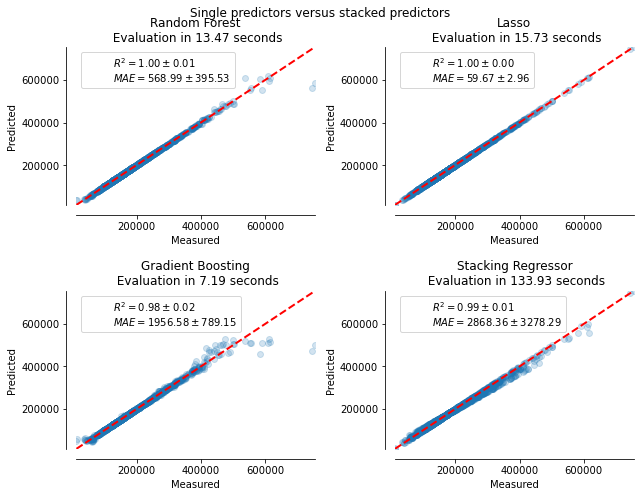

In [56]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
    ax.legend([extra], [scores], loc="upper left")
    title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    start_time = time.time()
    score = cross_validate(
        est, X_train, y_train, scoring=["r2", "neg_mean_absolute_error"], n_jobs=2, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X_train, y_train, n_jobs=2, verbose=0)

    plot_regression_results(
        ax,
        y_train,
        y_pred,
        name,
        (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
        ),
        elapsed_time,
    )

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()